<a href="https://colab.research.google.com/github/rajdeepd/tensorflow_2.0_book_code/blob/master/ch04/vgg19_all_images_25_epochs_colab_modelfit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
print('Google Colab? ' + str(IN_COLAB))

if not IN_COLAB:
#!python -m pip show tensorflow
  !which python
  !python -m pip show tensorflow

Google Colab? True


In [2]:
!pwd

/content


In [3]:


from google.colab import drive
drive.mount("/content/gdrive")


Mounted at /content/gdrive


In [4]:
!ls "/content/gdrive/My Drive/cancer_detection/metastatic_cancer"

model_summary		   plots_2.6.0_google_collab  training_logs_2.5.0
plots_2.4.1_google_collab  training		      training_logs_2.6.0
plots_2.5.0_google_collab  training_logs_2.4.1	      validation


In [5]:
%matplotlib inline

In [6]:
import sys
sys.executable

'/usr/bin/python3'

https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/applications/vgg19

In [9]:
# Imports
import numpy as np 
import pandas as pd 
from glob import glob 
from skimage.io import imread 
import os
import shutil
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [10]:
#!pip show tensorflow
TF_VERSION = tensorflow.__version__
TF_VERSION

'2.6.0'

In [11]:
if IN_COLAB:
  BASE = '/content/gdrive/My Drive/cancer_detection/metastatic_cancer'
else:
  BASE = '.'

In [12]:
# Output files
model_type='vgg19'
no_of_images = 'all'
EPOCHS = 25

if IN_COLAB:
  PLOTS = 'plots_'+ TF_VERSION + '_google_collab'
  VERSION = TF_VERSION
else:
  PLOTS = 'plots_' + TF_VERSION
  VERSION = TF_VERSION
  
_APPEND = '_' + model_type + '_' + str(no_of_images) + '_' + str(EPOCHS)  
APPEND = _APPEND + ".png"


if IN_COLAB:
  if not os.path.exists(BASE + "/training_logs_" + VERSION):
    os.mkdir(BASE + "/training_logs_" + VERSION)

  if not os.path.exists(BASE + "/model_summary/"):
    os.mkdir(BASE + "/model_summary/")
  if not os.path.exists(BASE + "/model_summary/" + "model_summary_" + VERSION):
    os.mkdir(BASE + "/model_summary/" + "model_summary_" + VERSION)
  if not os.path.exists(BASE + '/' + PLOTS):
    os.mkdir(BASE + '/' + PLOTS)
if IN_COLAB:
  TRAINING_LOGS_FILE = BASE + "/training_logs_" + VERSION + '/training_logs' + _APPEND + '.csv'
  MODEL_SUMMARY_FILE = BASE + "/model_summary/" "model_summary_" + VERSION + "/model_summary" + _APPEND + ".txt"
  MODEL_PLOT_FILE = BASE + '/' + PLOTS + "/model_plot_" + APPEND
  MODEL_FILE = "model_" + VERSION + "/model_" + model_type + "_all_collab.h5"
  TRAINING_PLOT_FILE = BASE + '/'+ PLOTS + "/training" +  APPEND
  VALIDATION_PLOT_FILE = BASE + '/'+  PLOTS + "/validation" + APPEND
  ROC_PLOT_FILE = BASE + '/'+  PLOTS + "/roc" + APPEND
else:
  TRAINING_LOGS_FILE = "training_logs_" + VERSION + '/training_logs' + _APPEND + '.csv'
  MODEL_SUMMARY_FILE = "model_summary_" + VERSION + "/model_summary" + _APPEND + ".txt"
  MODEL_PLOT_FILE = PLOTS + "/model_plot_" + APPEND
  MODEL_FILE = "model_" + VERSION + "/model_" + model_type + "_all_collab.h5"
  TRAINING_PLOT_FILE = PLOTS + "/training" +  APPEND
  VALIDATION_PLOT_FILE = PLOTS + "/validation" + APPEND
  ROC_PLOT_FILE = PLOTS + "/roc" + APPEND

In [13]:
# Hyperparams
SAMPLE_COUNT = 85000
#TRAINING_RATIO = 0.9
IMAGE_SIZE = 96 
IMAGE_SIZE2 = 224

BATCH_SIZE = 192
VERBOSITY = 1
TESTING_BATCH_SIZE = 5000

In [14]:
import pathlib
data_dir = pathlib.Path(BASE)
data_dir

PosixPath('/content/gdrive/My Drive/cancer_detection/metastatic_cancer')

In [15]:
data_dir_training = pathlib.Path(BASE + '/training')

In [16]:
image_count = len(list(data_dir_training.glob('*/*.tif')))
print(image_count)

360


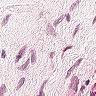

In [17]:
import PIL
import PIL.Image
zeros = list(data_dir_training.glob('0/*'))
PIL.Image.open(str(zeros[0]))

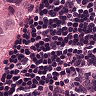

In [18]:
import PIL
import PIL.Image
zeros = list(data_dir_training.glob('1/*'))
PIL.Image.open(str(zeros[0]))

In [19]:
training_path=  BASE + '/training'
validation_path = BASE + '/validation'

In [20]:
# Data augmentation
training_data_generator = ImageDataGenerator(rescale=1./255,
                                             horizontal_flip=True,
                                             vertical_flip=True,
                                             rotation_range=180,
                                             zoom_range=0.4, 
                                             width_shift_range=0.3,
                                             height_shift_range=0.3,
                                             shear_range=0.3,
                                             channel_shift_range=0.3)

In [21]:
# Data generation
training_generator = training_data_generator.flow_from_directory(training_path,
                                                                 target_size=(IMAGE_SIZE2,IMAGE_SIZE2),
                                                                 batch_size=BATCH_SIZE,
                                                                 class_mode='binary')
validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_path,
                                                                              target_size=(IMAGE_SIZE2,
                                                                                           IMAGE_SIZE2),
                                                                              batch_size=BATCH_SIZE,
                                                                              class_mode='binary')
testing_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_path,
                                                                           target_size=(IMAGE_SIZE2,IMAGE_SIZE2),
                                                                           batch_size=BATCH_SIZE,
                                                                           class_mode='binary',
                                                                           shuffle=False)

Found 360 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [22]:
import tensorflow as tf
print(tf.__version__)

2.6.0


80150528/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 20,024,897
Trainable params: 20,024,897
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


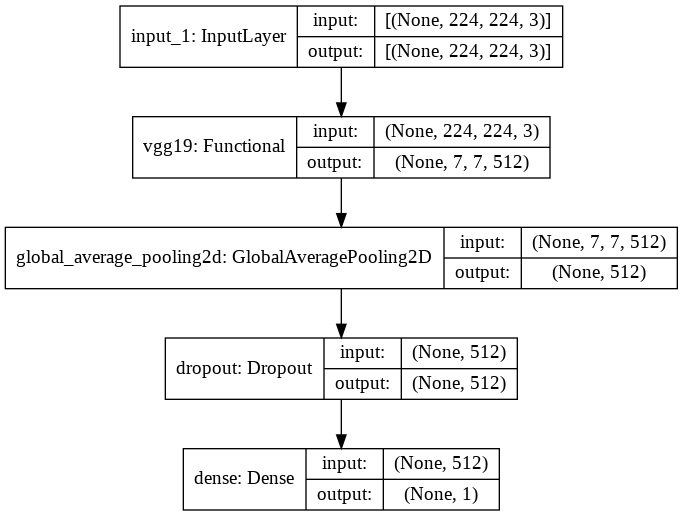

In [23]:
# Model
input_shape = (IMAGE_SIZE2, IMAGE_SIZE2, 3)
inputs = Input(input_shape)

vgg19 = VGG19(include_top=False, input_shape=(224, 224, 3))(inputs) 
outputs = GlobalAveragePooling2D()(vgg19)
outputs = Dropout(0.5)(outputs)
outputs = Dense(1, activation='sigmoid')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(lr=0.0001, decay=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

plot_model(model,
           to_file=MODEL_PLOT_FILE,
           show_shapes=True,
           show_layer_names=True)

In [24]:
import os
if not os.path.exists("training_logs_" + VERSION):
    os.makedirs("training_logs_" + VERSION)
file = open(TRAINING_LOGS_FILE, 'w+')

In [25]:
history = model.fit(training_generator,
                              steps_per_epoch=len(training_generator), 
                              validation_data=validation_generator,
                              validation_steps=len(validation_generator),
                              epochs=EPOCHS,
                              verbose=VERBOSITY,
                              callbacks=[#PlotLossesKeras(),
                                         ModelCheckpoint(MODEL_FILE,
                                                         monitor='val_accuracy',
                                                         verbose=VERBOSITY,
                                                         save_best_only=True,
                                                         mode='max'),
                                         CSVLogger(TRAINING_LOGS_FILE,
                                                   append=True,
                                                   separator=';')
                              ])

Epoch 1/25
2/2 [==============================] - 82s 42s/step - loss: 0.7398 - accuracy: 0.4917 - val_loss: 0.6933 - val_accuracy: 0.5250

Epoch 00001: val_accuracy improved from -inf to 0.52500, saving model to model_2.6.0/model_vgg19_all_collab.h5
Epoch 2/25
2/2 [==============================] - 71s 37s/step - loss: 0.6725 - accuracy: 0.6000 - val_loss: 0.6622 - val_accuracy: 0.5750

Epoch 00002: val_accuracy improved from 0.52500 to 0.57500, saving model to model_2.6.0/model_vgg19_all_collab.h5
Epoch 3/25
2/2 [==============================] - 71s 33s/step - loss: 0.6722 - accuracy: 0.5556 - val_loss: 0.6196 - val_accuracy: 0.5750

Epoch 00003: val_accuracy did not improve from 0.57500
Epoch 4/25
2/2 [==============================] - 71s 33s/step - loss: 0.6320 - accuracy: 0.6778 - val_loss: 0.7477 - val_accuracy: 0.5750

Epoch 00004: val_accuracy did not improve from 0.57500
Epoch 5/25
2/2 [==============================] - 71s 33s/step - loss: 0.6408 - accuracy: 0.6278 - val_lo

In [26]:
history.history

{'accuracy': [0.49166667461395264,
  0.6000000238418579,
  0.5555555820465088,
  0.6777777671813965,
  0.6277777552604675,
  0.7111111283302307,
  0.7166666388511658,
  0.7416666746139526,
  0.7555555701255798,
  0.7749999761581421,
  0.7805555462837219,
  0.7861111164093018,
  0.8138889074325562,
  0.8111110925674438,
  0.800000011920929,
  0.8138889074325562,
  0.8194444179534912,
  0.8111110925674438,
  0.8333333134651184,
  0.8083333373069763,
  0.8138889074325562,
  0.8111110925674438,
  0.8083333373069763,
  0.7833333611488342,
  0.8333333134651184],
 'loss': [0.7398380041122437,
  0.6724919676780701,
  0.6722488403320312,
  0.6319781541824341,
  0.6408432722091675,
  0.6074694991111755,
  0.5595833659172058,
  0.5618791580200195,
  0.5321216583251953,
  0.5135302543640137,
  0.5185258388519287,
  0.47951892018318176,
  0.45326533913612366,
  0.46529215574264526,
  0.4799496531486511,
  0.447265625,
  0.45569127798080444,
  0.4486212432384491,
  0.411057710647583,
  0.44909727573

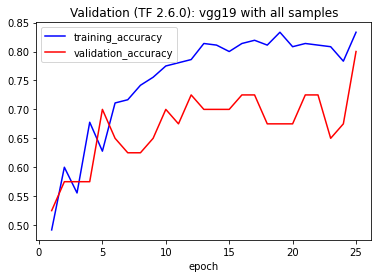

In [31]:
# Training plots
common_title = model_type + ' with ' + str(no_of_images) + ' samples'
epochs = [i for i in range(1, len(history.history['loss'])+1)]

plt.plot(epochs, history.history['loss'], color='blue', label="training_loss")
plt.plot(epochs, history.history['val_loss'], color='red', label="validation_loss")
plt.legend(loc='best')
#plt.title('training: ' + common_title)
plt.xlabel('epoch')
plt.savefig(TRAINING_PLOT_FILE, bbox_inches='tight')
plt.close()

plt.plot(epochs, history.history['accuracy'], color='blue', label="training_accuracy")
plt.plot(epochs, history.history['val_accuracy'], color='red',label="validation_accuracy")
plt.legend(loc='best')
plt.title('Validation (TF '+ VERSION + '): ' + common_title )
plt.xlabel('epoch')
plt.savefig(VALIDATION_PLOT_FILE, bbox_inches='tight')
plt.show()
plt.close()

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1/1 [==============================] - 2s 2s/step


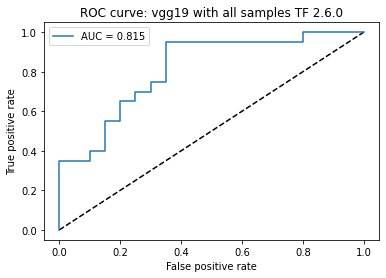

In [30]:
# ROC testing plot
#model.load_weights(MODEL_FILE)
predictions = model.predict_generator(testing_generator, steps=len(testing_generator), verbose=VERBOSITY)
false_positive_rate, true_positive_rate, threshold = roc_curve(testing_generator.classes, predictions)
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve: ' + common_title + ' TF '+ VERSION)
plt.legend(loc='best')
plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.show()
plt.close()